# TBATS Model Creation

Clayton Miller - miller.clayton@gmail.com

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import timeit
import os
from datetime import datetime
from __future__ import division
from pylab import *
import matplotlib.dates as mdates
from matplotlib import ticker
import datetime
import matplotlib

In [3]:
import rpy2

In [4]:
sns.set_style("whitegrid")

In [5]:
%matplotlib inline
%load_ext rpy2.ipython 

In [6]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [7]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)

In [8]:
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')

# Calculate Breakouts

In [86]:
%%R 
library(forecast)
library(stats)

In [87]:
testbuilding = "PrimClass_Everett"

In [132]:
timezone = meta.T[building].timezone
start = meta.T[building].datastart
end = meta.T[building].dataend
building_data = temp[building].tz_convert(timezone).truncate(before=start,after=end).resample('D').sum()
data = building_data.reset_index(drop=True)
    

In [133]:
year = start.year
month = start.month
day = start.day

In [134]:
freq = len(data)

In [135]:
%Rpush data
%Rpush freq
%Rpush year
%Rpush month
%Rpush day


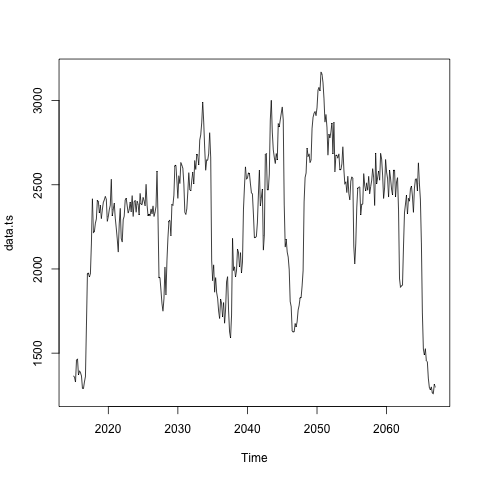

In [136]:
%R df <- as.numeric(data)
%R data <- unname(df, force = FALSE)
%R data.ts <- ts(data, start=c(year,month,day), freq=7)
%R plot(data.ts)

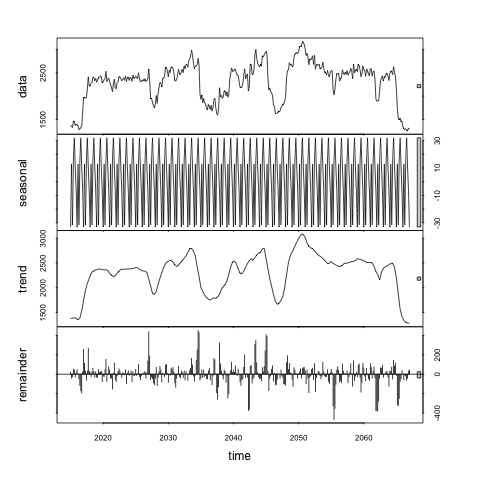

In [142]:
%R data.stl <- stl(data.ts, s.window="periodic", robust=TRUE)
%R plot(data.stl)

In [156]:
%R remainder <- data.stl$time.series[,"remainder"]
%R 

array([  1.87548342e+01,  -4.03681073e+01,  -2.78500835e+01,
         5.21949960e+01,   4.15810611e+01,  -3.04537411e+01,
         1.34795739e+01,   4.73390643e+01,   4.44945136e-01,
        -4.85124020e+01,  -1.16963431e+02,  -1.71144438e+02,
        -1.94614004e+02,   2.31231758e+01,   2.57246083e+02,
         1.12646722e+02,   3.12133879e+01,  -6.27059188e+01,
         3.17907721e+01,   2.67457256e+02,   3.24668762e+01,
         1.73121534e+01,  -2.56461973e+01,   2.03994876e+01,
         6.08514275e+01,   2.61771030e+01,  -3.21441215e+01,
         2.49245812e+01,  -3.21210340e+01,  -3.25846390e+01,
         4.72927182e+01,   1.74184733e+01,   2.19602337e+01,
         3.11167133e+01,  -7.66085932e+01,  -1.97045650e+01,
        -2.38791358e+01,   4.64232247e+01,   1.51981877e+02,
        -7.43448000e+01,  -5.73497985e+00,   7.64814801e+01,
         4.40336115e+01,  -4.10441993e+01,  -4.18810540e+01,
        -1.53804346e+02,   1.11883675e+01,   1.12782136e+02,
        -5.67559205e+01,

In [153]:
%R print(trend)

NULL


In [144]:
%R data.stl$weights

array([ 0.99006959,  0.95453698,  0.97813615,  0.92449527,  0.95178137,
        0.97396702,  0.9948753 ,  0.93764986,  0.99999394,  0.93433782,
        0.65031401,  0.34295032,  0.21553038,  0.9851234 ,  0.00436614,
        0.67393461,  0.97277688,  0.89204043,  0.97167141,  0.        ,
        0.97044771,  0.99153174,  0.98153443,  0.98833271,  0.89809142,
        0.98074995,  0.97102272,  0.98252725,  0.97110753,  0.97026817,
        0.93794372,  0.9914351 ,  0.98643472,  0.9728433 ,  0.84110117,
        0.98909035,  0.98399168,  0.94015335,  0.45385191,  0.84996808,
        0.99907239,  0.84158189,  0.9459296 ,  0.95301825,  0.95094874,
        0.44348216,  0.996476  ,  0.67302774,  0.91107499,  0.84083062,
        0.99495654,  0.97607417,  0.91841503,  0.96724305,  0.99941181,
        0.96891901,  0.99603116,  0.9969278 ,  0.99991202,  0.94521605,
        0.74913991,  0.99788702,  0.96925095,  0.99588472,  0.99859797,
        0.97297195,  0.83235605,  0.97879592,  0.9914374 ,  0.99

In [65]:
# %R df <- as.numeric(data)
# %R data <- unname(df, force = FALSE)

In [52]:
def get_breakouts(temp, meta, building, Minimum, Beta, Degrees):
    
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    building_data = temp[building].tz_convert(timezone).truncate(before=start,after=end).resample('D').sum()
    data = building_data.reset_index(drop=True)
    
    %Rpush data
    %Rpush Minimum
    %Rpush Beta
    %Rpush Degrees

    %R df <- as.numeric(data)
    %R data <- unname(df, force = FALSE)
    %R res = breakout(data, min.size=Minimum, method='multi', beta=Beta, degree=Degrees)

    #%R res = breakout(data, min.size=Minimum, method='multi', beta=.001, degree=1, plot=TRUE)
    %R locations = res$loc
    %Rpull locations
    
    prevloc = 0
    bo_counter = 0
    for location in locations:
        building_data[prevloc:location] = bo_counter
        prevloc = location
        bo_counter+=1
    building_data[prevloc:] = bo_counter
    breakout = pd.DataFrame({building:building_data})
    
    return breakout

In [53]:
minimum = 30
beta = 0.005
degrees = 3

In [54]:
building = "UnivDorm_Cooper"

In [55]:
breakout = get_breakouts(temp, meta, building, minimum, beta, degrees)

In [57]:
#breakout

In [118]:
def get_individual_data(temp, meta, building):
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))

def get_individual_data_notz(temp, meta, building):
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].truncate(before=start,after=end))

In [119]:
def plot_line_example(df_1, df_2,  color):
    sns.set(rc={"figure.figsize": (12,4)})
    sns.set_style('whitegrid')
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    df_1.columns = ["Actual kWh"]
    #df_predicted.columns = ["Predicted kWh"]
    ax1 = fig.add_subplot(gs[1:60,:])
    df_1.plot(ax = ax1, legend=False)
    ax1.xaxis.set_visible(False)
    ax1.set_title("Hourly kWh")
    
    ax2 = fig.add_subplot(gs[68:,:])
    #df_2 = df_2.tz_localize(None)
    x = mdates.drange(df_2.index[0], df_2.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df_2.columns), len(df_2.columns)+1)
    data = np.array(df_2.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap)
    ax2.set_title("Number of breakouts indicating shifts in long-term steady state")
    
    #leftspacing, 
    cbaxes = fig.add_axes([0.18, 0.08, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax2, orientation='horizontal', cax=cbaxes)
    tick_locator = ticker.MaxNLocator(nbins=7)
    cbar.locator = tick_locator
    cbar.update_ticks()
    
    ax2.axis('tight')
    ax2.xaxis_date()
    ax2.yaxis.set_visible(False)
    myFmt = mdates.DateFormatter('%b')
    ax2.xaxis.set_major_formatter(myFmt)

In [120]:
# start = '2015-07-01'
# end = '2015-09-30'

In [121]:
breakout.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2015-01-01 00:00:00-05:00 to 2015-12-31 00:00:00-05:00
Freq: D
Data columns (total 1 columns):
UnivDorm_Cooper    365 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [122]:
df = get_individual_data(temp, meta, building)
#df = df.truncate(before=start,after=end)#
#breakout = breakout#.truncate(before=start,after=end)

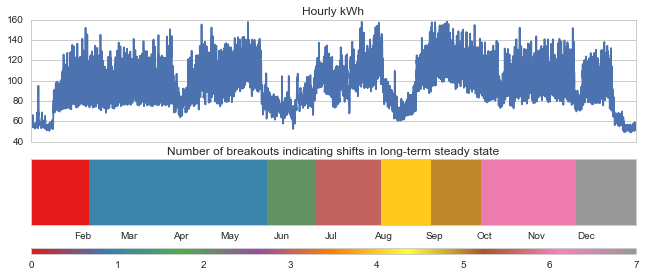

In [123]:
plot_line_example(df, breakout, "Set1")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/breakout_example.png"));

In [124]:
#sns.palplot(sns.light_palette("viridis"))

# Loop though all buildings

In [135]:
minimum = 30
beta = 0.005
degrees = 3
breakouts = pd.DataFrame()
for building in meta.index:
    breakout = get_breakouts(temp, meta, building, minimum, beta, degrees)
    breakout = breakout.reset_index(drop=True)
    breakouts = pd.merge(breakouts, breakout, right_index=True, left_index=True, how='outer')

In [136]:
breakouts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 1.4 MB


# Overview heatmap

In [153]:
def heatmap_data(df):
    x = np.linspace(0, len(df.index), len(df.index)+1)
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    return x,y

#This function changes the year for all of the buildings so that they can be overlapped for plotting
# THE RESULTING DATAFRAME IS ONLY FOR "GENERALIZED" PLOTTING TO GET THE DATA SETS TO OVERLAP -- DON'T PERFORM CALCULATIONS ON IT

def changeto2015(x):
    try:
        return x.replace(year=2015)
    except:
        return np.nan
    
def is_leap_and_29Feb(s):
    return (s.index.year % 4 == 0) & ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & (s.index.month == 2) & (s.index.day == 29)

def generalize_timestamp_forplotting(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        timezone = meta.T[building].timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def generalize_timestamp_forplotting_notz(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def plotmap(df, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel):
    
    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    
    numberofplots = 1
    fig = plt.figure()
    
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    ax = fig.add_subplot(numberofplots, 1, 1)
    data = np.array(df.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    qmesh = ax.pcolormesh(x, y, datam, cmap=cmap)
    
    cbaxes = fig.add_axes([0.15, 0.15, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax=cbaxes)
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)
    
    ax.axis('tight')
    ax.xaxis_date()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    ax.set_xlabel(xaxislabel)
    ax.set_ylabel(yaxislabel)
    ax.set_title(graphiclabel)
    
    ax.set_yticklabels(df.columns)
    tick_locator = ticker.MaxNLocator(nbins=110)
    loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.locator_params(axis='y', nbins=100)
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.subplots_adjust(bottom=0.2)

def plotmap_subplots(df, meta, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel, z_min, z_max):

    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    cmap = matplotlib.cm.get_cmap(color)
    
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    # Plot Offices
    df_office = df[df.columns[df.columns.str.contains("Office")]]
    office_height = int(len(df_office.T)/len(df.T)*100-2)
    ax1 = fig.add_subplot(gs[1:office_height,:])
    x,y = heatmap_data(df_office)
    data = np.array(df_office.T)
    datam = np.ma.array(data, mask=np.isnan(df_office))
    qmesh = ax1.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax1.axis('tight')
    #ax1.xaxis_date()
    ax1.set_title("Offices")
    ax1.xaxis.set_visible(False)
    
    # Plot UnivLab
    df_lab = df[df.columns[df.columns.str.contains("UnivLab")]]
    lab_height = int(len(df_lab.T)/len(df.T)*100-2)
    ax2 = fig.add_subplot(gs[office_height+2:office_height+lab_height,:])
    x,y = heatmap_data(df_lab)
    data = np.array(df_lab.T)
    datam = np.ma.array(data, mask=np.isnan(df_lab))
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax2.axis('tight')
    #ax2.xaxis_date()
    ax2.set_title("University Labs")
    ax2.xaxis.set_visible(False)
    
    # Plot UnivClass
    df_uniclass = df[df.columns[df.columns.str.contains("UnivClass")]]
    uniclass_height = int(len(df_uniclass.T)/len(df.T)*100-2)
    ax3 = fig.add_subplot(gs[office_height+lab_height+2:office_height+lab_height+uniclass_height,:])
    x,y = heatmap_data(df_uniclass)
    data = np.array(df_uniclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_uniclass))
    qmesh = ax3.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax3.axis('tight')
    #ax3.xaxis_date()
    ax3.set_title("University Classrooms")
    ax3.xaxis.set_visible(False)

    # Plot PrimClass
    df_primclass = df[df.columns[df.columns.str.contains("PrimClass")]]
    primclass_height = int(len(df_primclass.T)/len(df.T)*100-2)
    ax4 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+2:office_height+lab_height+uniclass_height+primclass_height,:])
    x,y = heatmap_data(df_primclass)
    data = np.array(df_primclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_primclass))
    qmesh = ax4.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax4.axis('tight')
    #ax4.xaxis_date()
    ax4.set_title("Primary/Secondary Classroom")
    ax4.xaxis.set_visible(False)

    
    # Plot Univ Dorms
    df_unidorm = df[df.columns[df.columns.str.contains("UnivDorm")]]
    unidorm_height = int(len(df_unidorm.T)/len(df.T)*100-2)
    ax5 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+primclass_height+2:office_height+lab_height+uniclass_height+primclass_height+unidorm_height,:])
    x,y = heatmap_data(df_unidorm)
    data = np.array(df_unidorm.T)
    datam = np.ma.array(data, mask=np.isnan(df_unidorm))
    qmesh = ax5.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax5.axis('tight')
    #ax5.xaxis_date()
    ax5.set_title("University Dorms")
    
    cbaxes = fig.add_axes([0.18, 0.23, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, orientation='horizontal', cax=cbaxes) #ax=ax,
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)

    #myFmt = mdates.DateFormatter('%b')
    #ax5.xaxis.set_major_formatter(myFmt)
    
    fig.text(0.14, 0.5, yaxislabel, va='center', rotation='vertical')

Plotting the data all in one year doesn't make sense as it MUST be sequential -- we just use a simple integer index

In [154]:
#temp_breakouts_generalized = generalize_timestamp_forplotting_notz(meta, breakouts)#.ffill().bfill()

In [155]:
temp_breakouts_sorted = breakouts[list(breakouts.max().sort_values().index)]

In [156]:
temp_breakouts_sorted.describe().T['min'].describe()

count    507.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: min, dtype: float64

In [157]:
temp_breakouts_sorted.describe().T['max'].describe()

count    507.000000
mean       4.382643
std        2.488617
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       10.000000
Name: max, dtype: float64

In [160]:
#temp_breakouts_sorted

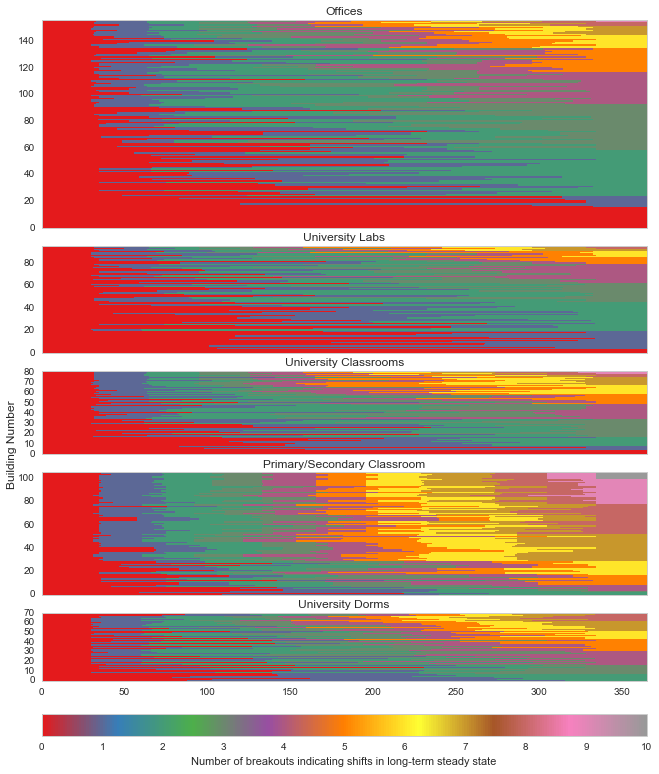

In [161]:
plotmap_subplots(temp_breakouts_sorted.dropna(), meta, 'Set1', "Number of breakouts indicating shifts in long-term steady state",
                 " ", "Building Number", " ", " ", 0, 10)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/breakouts_heatmap.png"));

In [ ]:
#temp_spearman_generalized.describe(include="all")

In [122]:
#from pandas_summary import DataFrameSummary

In [123]:
#dfs = DataFrameSummary(temp_spearman_generalized)

In [120]:
#building

In [119]:
#dfs[building]["top_correlations"]